/var/folders/51/g_93hnkd62n65g_b4xfjnljw0000gn/T/ipykernel_33912/3478508363.py:4: DeprecationWarning: numpy.core.defchararray is deprecated and has been renamed to numpy._core.defchararray. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.defchararray.upper.
  from numpy.core.defchararray import upper


[530.3065120163665, 515.5974453196653, 515.5974453196653, 326.3416291491334, 324.61694834724364, 270.2530490231388, 270.2530490231388, 216.5640392665699, 216.28489366655145, 175.15072087790253, 175.08047396732385, 158.01633868433984, 158.0835043394574, 136.65661019753043, 136.5382948451516, 117.58799172449261, 117.50123660057702, 111.08642561360536, 110.52292244157454, 100.5112842983297]


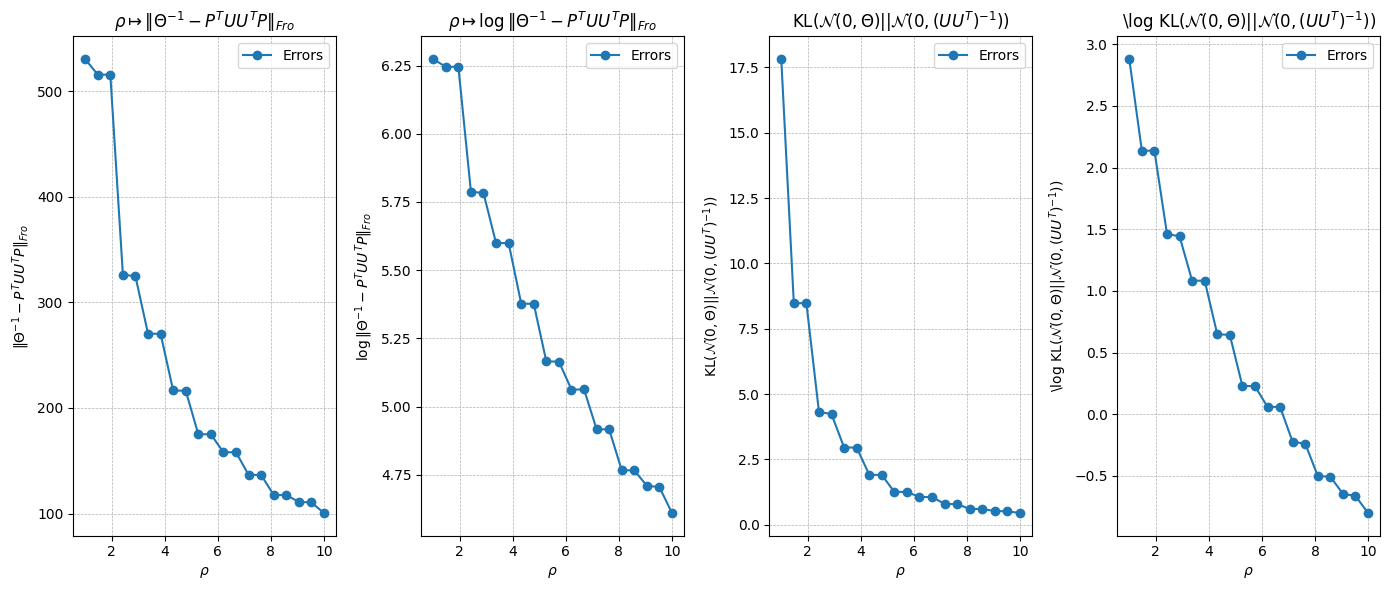

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.core.defchararray import upper

from pyKoLesky.cholesky import *
from pyKoLesky.ordering import *

torch.set_default_dtype(torch.float64)


def periodic_laplacian(N, x):
    """
    Create a periodic Laplacian matrix for N points on the domain defined by x.
    Args:
        N (int): Number of grid points.
        x (torch.Tensor): Grid points (1D tensor of shape (N,)).

    Returns:
        torch.Tensor: NxN periodic Laplacian matrix.
    """
    dx = x[1] - x[0]  # Assume uniform spacing

    # Initialize the Laplacian matrix
    L = torch.zeros((N, N), dtype=torch.float64)

    # Fill in the Laplacian matrix with periodic boundary conditions
    for i in range(N):
        L[i, (i - 1) % N] = 1  # Left neighbor (periodic)
        L[i, i] = -2            # Diagonal
        L[i, (i + 1) % N] = 1  # Right neighbor (periodic)

    # Scale by dx^2
    L = L / (dx**2)

    return L


# Gaussian kernel function
def gaussian_kernel(x1, x2, sigma=0.1):
    return torch.exp(-((x1 - x2.T) ** 2) / (2 * sigma ** 2))

N = 50  # Number of points
x = torch.linspace(0, 1, N)[:, None]
sigma = 1  # Length scale of the kernel
Theta = gaussian_kernel(x, x, sigma=sigma) + 1e-2 * torch.eye(N)

# A = -periodic_laplacian(N, x)
# Theta = A @ A.T + 1e-3 * torch.eye(N)

# N = 5
# A = torch.tensor([[4.0, 1.0, 0.5, 0.0, 0.0],
#                       [1.0, 3.0, 0.5, 0.0, 0.0],
#                       [0.5, 0.5, 2.0, 1.0, 0.0],
#                       [0.0, 0.0, 1.0, 3.0, 0.5],
#                       [0.0, 0.0, 0.0, 0.5, 1.0]])
# Theta = A @ A.T + 1e-3 * torch.eye(N)  # Ensure positive definiteness
#
# x = torch.linspace(0, 1, 6)[1:][:, None]

# Range of rho values (log scale)
# rho_values = torch.linspace(1, 100, 200)  # Rho values from 0.1 to ~30
# rho_values = torch.logspace(0.0, 2.0, steps=20)

rho_values = torch.linspace(1, 10, 20)

KLerrors = []   # KL distances
errors = []

Perm, lengths = maximin(x)

L = torch.linalg.cholesky(Theta)
Theta_inverse = torch.cholesky_inverse(L, upper=False)

for rho in rho_values:
    ########################################################
    # Compute permutation and sparsity pattern
    sparsity = sparsity_pattern(x[Perm], lengths, rho)
    # Compute sparse Cholesky decomposition
    U_sparse = sparse_cholesky(Theta, Perm, sparsity)
    # Convert sparse tensor to dense (if needed)
    U_dense = U_sparse.to_dense()
    # Reconstruct Theta^-1
    invPerm = torch.argsort(Perm)
    Theta_inverse_reconstructed = (U_dense @ U_dense.T)[invPerm][:, invPerm]

    Theta_ordered = Theta[Perm][:, Perm]
    mtx = U_dense.T @ Theta_ordered @ U_dense
    klerror = 1/2 * (-torch.log(torch.linalg.det(mtx)) + torch.trace(mtx) - len(mtx))

    # Compute reconstruction error (Frobenius norm)
    reconstruction_error = torch.linalg.norm(Theta_inverse - Theta_inverse_reconstructed, ord='fro')
    # reconstruction_error = torch.linalg.norm(torch.eye(len(x)) - Theta @ Theta_inverse_reconstructed, ord='fro')
    # errors.append(torch.log(reconstruction_error).item())
    errors.append(reconstruction_error.item())
    KLerrors.append(klerror.item())

print(errors)
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 4, figsize=(14, 6))

# First Subplot: Original Scale
axs[0].plot(rho_values.numpy(), errors, marker='o', label='Errors')
axs[0].set_xlabel(r'$\rho$')
axs[0].set_ylabel(r'$\|\Theta^{-1} - P^TUU^TP\|_{Fro}$')
axs[0].set_title(r'$\rho \mapsto \|\Theta^{-1} - P^TUU^TP\|_{Fro}$')
axs[0].legend()
axs[0].grid(True, linestyle='--', linewidth=0.5)

# Second Subplot: Log-Scale
axs[1].plot(rho_values.numpy(), np.log(errors), marker='o', label='Errors')
axs[1].set_xlabel(r'$\rho$')
axs[1].set_ylabel(r'$\log\|\Theta^{-1} - P^TUU^TP\|_{Fro}$')
axs[1].set_title(r'$\rho \mapsto \log\|\Theta^{-1} - P^TUU^TP\|_{Fro}$')
axs[1].legend()
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

axs[2].plot(rho_values.numpy(), KLerrors, marker='o', label='Errors')
axs[2].set_xlabel(r'$\rho$')
axs[2].set_ylabel(r'KL$(\mathcal{N}(0, \Theta) || \mathcal{N}(0, (UU^T)^{-1}))$')
axs[2].set_title(r'KL$(\mathcal{N}(0, \Theta) || \mathcal{N}(0, (UU^T)^{-1}))$')
axs[2].legend()
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)


axs[3].plot(rho_values.numpy(), np.log(KLerrors), marker='o', label='Errors')
axs[3].set_xlabel(r'$\rho$')
axs[3].set_ylabel(r'\log KL$(\mathcal{N}(0, \Theta) || \mathcal{N}(0, (UU^T)^{-1}))$')
axs[3].set_title(r'\log KL$(\mathcal{N}(0, \Theta) || \mathcal{N}(0, (UU^T)^{-1}))$')
axs[3].legend()
axs[3].grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


# Demonstration of the accuracy of the sparse Cholesky factorization. We choose Matern kernels with $\nu=5/2, 7/2, 9/2$ and lengthscales $l=0.3$, the physical points are fixed to be equidistributed in $[0, 1]^2$ with grid size $h=0.05$. We plot the error measured w.r.t $\rho$.

In [2]:
import torch
import numpy as np
from scipy.special import gamma
import math

# Parameters
#nu_values = [torch.tensor(5/2), torch.tensor(7/2), torch.tensor(9.2)]  # Matern nu values
nu_values = [5/2, 7/2, 9/2]

lengthscale = 0.3  # Lengthscale
h = 0.05  # Grid spacing
grid_size = int(1 / h)  # Number of points along one dimension

# Generate equidistributed points in [0, 1]^2
x = torch.linspace(0, 1, grid_size)
X = torch.cartesian_prod(x, x)
# print(X.shape)
# Matern kernel function
def matern_kernel_half_integer(X1, X2, nu, lengthscale, sigma=1.0):
    # Compute pairwise distances
    dist = torch.cdist(X1, X2, p=2)  # Euclidean distance

    # Common term sqrt(2p+1) / rho
    p = int(nu - 1/2)  # Get p from nu = p + 1/2
    sqrt_term = math.sqrt(2 * p + 1) / lengthscale
    exp_term = torch.exp(-sqrt_term * dist)

    block = sqrt_term * dist
    if nu == 5/2:
        term1 = 1
        term2 = block
        term3 = block**2 / 3
        polynomial = term1 + term2 + term3
        K = sigma**2 * polynomial * exp_term

    elif nu == 7/2:
        term1 = 1
        term2 = block
        term3 = 2 * block ** 2 / 5
        term4 = block ** 3 / 15
        polynomial = term1 + term2 + term3 + term4
        K = sigma**2 * polynomial * exp_term

    elif nu == 9/2:
        term1 = 1
        term2 = block
        term3 = 3/7 * block ** 2
        term4 = 2/21 * block ** 3
        term5 = 1/105 * block ** 4
        polynomial = term1 + term2 + term3 + term4 + term5
        K = sigma**2 * polynomial * exp_term

    else:
        raise ValueError("Unsupported value of nu. Supported values are 5/2, 7/2, and 9/2.")

    return K

# Formulate the covariance matrix K for each nu value
K_matrices = {}
for nu in nu_values:
    K = matern_kernel_half_integer(X, X, nu, lengthscale)
    K_matrices[float(nu)] = K

# # Example: Access covariance matrix for nu = 5/2
# K_5_2 = K_matrices[float(9/2)]
# print(K_5_2)


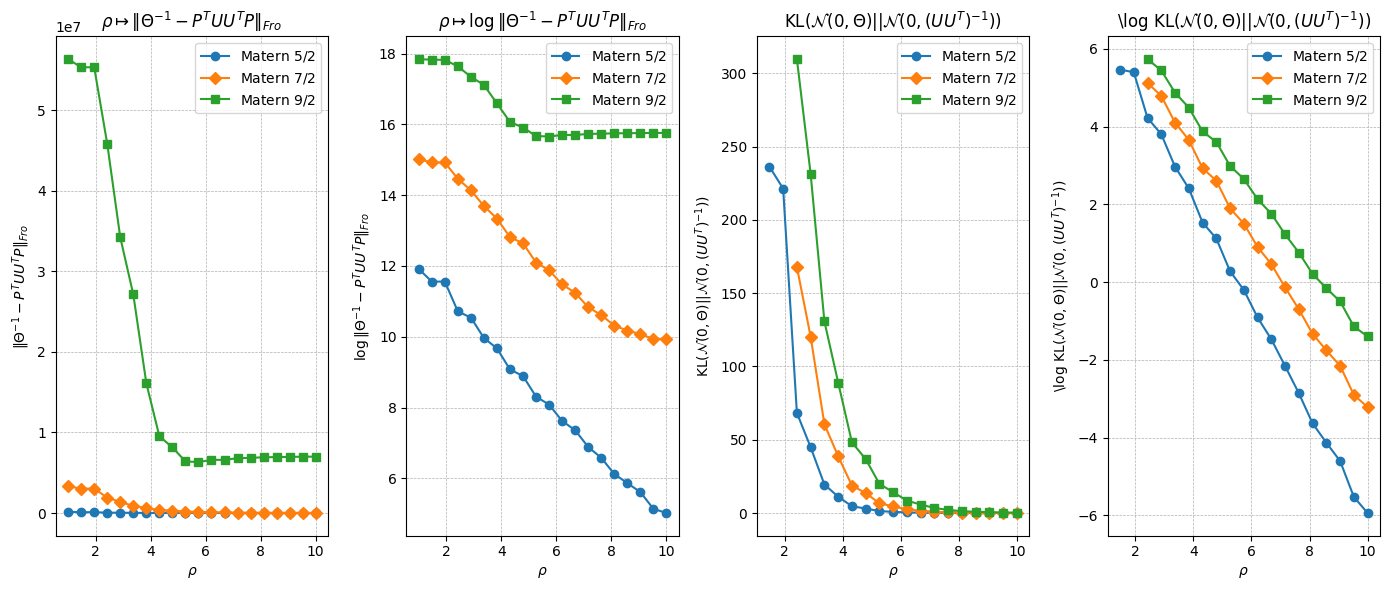

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pyKoLesky.cholesky import *
from pyKoLesky.ordering import *

torch.set_default_dtype(torch.float64)



N = len(X)
x = X

fig, axs = plt.subplots(1, 4, figsize=(14, 6))
markers = ['o', 'D', 's']
labels = [r'Matern $5/2$', r'Matern $7/2$', r'Matern $9/2$']

for index, nu in enumerate(nu_values):
    Theta = K_matrices[float(nu)]

    rho_values = torch.linspace(1, 10, 20)

    KLerrors = []   # KL distances
    errors = []

    Perm, lengths = maximin(x)

    L = torch.linalg.cholesky(Theta + 1e-8 * torch.eye(len(Theta)))
    Theta_inverse = torch.cholesky_inverse(L, upper=False)

    for rho in rho_values:
        ########################################################
        # Compute permutation and sparsity pattern
        sparsity = sparsity_pattern(x[Perm], lengths, rho)
        # Compute sparse Cholesky decomposition
        U_sparse = sparse_cholesky(Theta, Perm, sparsity)
        # Convert sparse tensor to dense (if needed)
        U_dense = U_sparse.to_dense()
        # Reconstruct Theta^-1
        invPerm = torch.argsort(Perm)
        Theta_inverse_reconstructed = (U_dense @ U_dense.T)[invPerm][:, invPerm]

        Theta_ordered = Theta[Perm][:, Perm]
        mtx = U_dense.T @ Theta_ordered @ U_dense
        klerror = 1/2 * (-torch.log(torch.linalg.det(mtx)) + torch.trace(mtx) - len(mtx))

        # Compute reconstruction error (Frobenius norm)
        reconstruction_error = torch.linalg.norm(Theta_inverse - Theta_inverse_reconstructed, ord='fro')
        # reconstruction_error = torch.linalg.norm(torch.eye(len(x)) - Theta @ Theta_inverse_reconstructed, ord='fro')
        # errors.append(torch.log(reconstruction_error).item())
        errors.append(reconstruction_error.item())
        KLerrors.append(klerror.item())


    # First Subplot: Original Scale
    axs[0].plot(rho_values.numpy(), errors, marker=markers[index], label=labels[index])
    axs[0].set_xlabel(r'$\rho$')
    axs[0].set_ylabel(r'$\|\Theta^{-1} - P^TUU^TP\|_{Fro}$')
    axs[0].set_title(r'$\rho \mapsto \|\Theta^{-1} - P^TUU^TP\|_{Fro}$')
    axs[0].legend()
    axs[0].grid(True, linestyle='--', linewidth=0.5)

    # Second Subplot: Log-Scale
    axs[1].plot(rho_values.numpy(), np.log(errors), marker=markers[index], label=labels[index])
    axs[1].set_xlabel(r'$\rho$')
    axs[1].set_ylabel(r'$\log\|\Theta^{-1} - P^TUU^TP\|_{Fro}$')
    axs[1].set_title(r'$\rho \mapsto \log\|\Theta^{-1} - P^TUU^TP\|_{Fro}$')
    axs[1].legend()
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    axs[2].plot(rho_values.numpy(), KLerrors, marker=markers[index], label=labels[index])
    axs[2].set_xlabel(r'$\rho$')
    axs[2].set_ylabel(r'KL$(\mathcal{N}(0, \Theta) || \mathcal{N}(0, (UU^T)^{-1}))$')
    axs[2].set_title(r'KL$(\mathcal{N}(0, \Theta) || \mathcal{N}(0, (UU^T)^{-1}))$')
    axs[2].legend()
    axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)


    axs[3].plot(rho_values.numpy(), np.log(KLerrors), marker=markers[index], label=labels[index])
    axs[3].set_xlabel(r'$\rho$')
    axs[3].set_ylabel(r'\log KL$(\mathcal{N}(0, \Theta) || \mathcal{N}(0, (UU^T)^{-1}))$')
    axs[3].set_title(r'\log KL$(\mathcal{N}(0, \Theta) || \mathcal{N}(0, (UU^T)^{-1}))$')
    axs[3].legend()
    axs[3].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Adjust layout to prevent overlap
    plt.tight_layout()

# Display the plots
plt.show()


# We fix the Matern kernels with $\nu=5/2$ and lengthscale $l=0.3$. We vary the number of physical points

In [5]:
import torch
import numpy as np
from scipy.special import gamma
import math

# print(X.shape)
# Matern kernel function
def matern_kernel_half_integer(X1, X2, nu, lengthscale, sigma=1.0):
    # Compute pairwise distances
    dist = torch.cdist(X1, X2, p=2)  # Euclidean distance

    # Common term sqrt(2p+1) / rho
    p = int(nu - 1/2)  # Get p from nu = p + 1/2
    sqrt_term = math.sqrt(2 * p + 1) / lengthscale
    exp_term = torch.exp(-sqrt_term * dist)

    block = sqrt_term * dist
    if nu == 5/2:
        term1 = 1
        term2 = block
        term3 = block**2 / 3
        polynomial = term1 + term2 + term3
        K = sigma**2 * polynomial * exp_term

    elif nu == 7/2:
        term1 = 1
        term2 = block
        term3 = 2 * block ** 2 / 5
        term4 = block ** 3 / 15
        polynomial = term1 + term2 + term3 + term4
        K = sigma**2 * polynomial * exp_term

    elif nu == 9/2:
        term1 = 1
        term2 = block
        term3 = 3/7 * block ** 2
        term4 = 2/21 * block ** 3
        term5 = 1/105 * block ** 4
        polynomial = term1 + term2 + term3 + term4 + term5
        K = sigma**2 * polynomial * exp_term

    else:
        raise ValueError("Unsupported value of nu. Supported values are 5/2, 7/2, and 9/2.")

    return K


# Parameters
#nu_values = [torch.tensor(5/2), torch.tensor(7/2), torch.tensor(9.2)]  # Matern nu values
nu = 5/2

hs = [0.04, 0.02, 0.01]
grid_sizes = [int(1 / h) for h in hs]  # Number of points along one dimension

lengthscale = 0.3  # Lengthscale

# Formulate the covariance matrix K for each nu value
K_matrices = {}
for grid_size in grid_sizes:
    x = torch.linspace(0, 1, grid_size)
    X = torch.cartesian_prod(x, x)
    K = matern_kernel_half_integer(X, X, nu, lengthscale)
    K_matrices[grid_size] = K

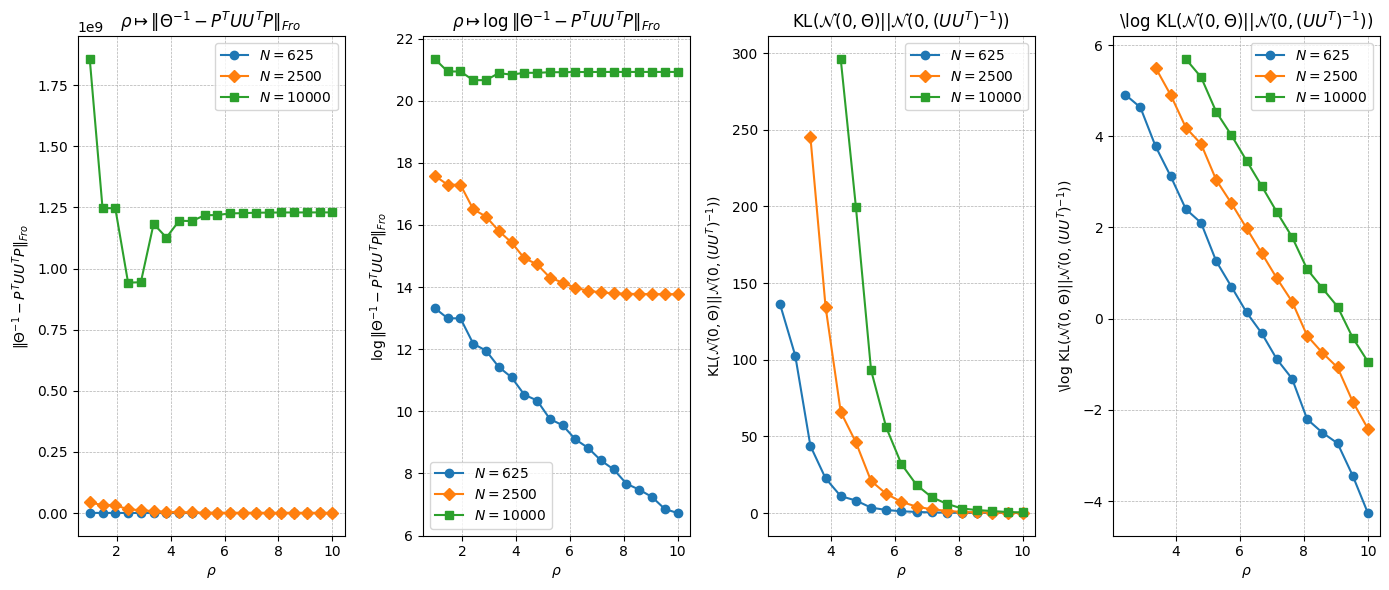

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pyKoLesky.cholesky import *
from pyKoLesky.ordering import *

torch.set_default_dtype(torch.float64)

fig, axs = plt.subplots(1, 4, figsize=(14, 6))
markers = ['o', 'D', 's']
labels = [r'$N = 625$', r'$N = 2500$', r'$N = 10000$']

for index, grid_size in enumerate(grid_sizes):
    x = torch.linspace(0, 1, grid_size)
    x = torch.cartesian_prod(x, x)
    N = len(x)

    Theta = K_matrices[grid_size]

    rho_values = torch.linspace(1, 10, 20)

    KLerrors = []   # KL distances
    errors = []

    Perm, lengths = maximin(x)

    L = torch.linalg.cholesky(Theta + 1e-8 * torch.eye(len(Theta)))
    Theta_inverse = torch.cholesky_inverse(L, upper=False)

    for rho in rho_values:
        ########################################################
        # Compute permutation and sparsity pattern
        sparsity = sparsity_pattern(x[Perm], lengths, rho)
        # Compute sparse Cholesky decomposition
        U_sparse = sparse_cholesky(Theta, Perm, sparsity)
        # Convert sparse tensor to dense (if needed)
        U_dense = U_sparse.to_dense()
        # Reconstruct Theta^-1
        invPerm = torch.argsort(Perm)
        Theta_inverse_reconstructed = (U_dense @ U_dense.T)[invPerm][:, invPerm]

        Theta_ordered = Theta[Perm][:, Perm]
        mtx = U_dense.T @ Theta_ordered @ U_dense
        klerror = 1/2 * (-torch.log(torch.linalg.det(mtx)) + torch.trace(mtx) - len(mtx))

        # Compute reconstruction error (Frobenius norm)
        reconstruction_error = torch.linalg.norm(Theta_inverse - Theta_inverse_reconstructed, ord='fro')
        # reconstruction_error = torch.linalg.norm(torch.eye(len(x)) - Theta @ Theta_inverse_reconstructed, ord='fro')
        # errors.append(torch.log(reconstruction_error).item())
        errors.append(reconstruction_error.item())
        KLerrors.append(klerror.item())


    # First Subplot: Original Scale
    axs[0].plot(rho_values.numpy(), errors, marker=markers[index], label=labels[index])
    axs[0].set_xlabel(r'$\rho$')
    axs[0].set_ylabel(r'$\|\Theta^{-1} - P^TUU^TP\|_{Fro}$')
    axs[0].set_title(r'$\rho \mapsto \|\Theta^{-1} - P^TUU^TP\|_{Fro}$')
    axs[0].legend()
    axs[0].grid(True, linestyle='--', linewidth=0.5)

    # Second Subplot: Log-Scale
    axs[1].plot(rho_values.numpy(), np.log(errors), marker=markers[index], label=labels[index])
    axs[1].set_xlabel(r'$\rho$')
    axs[1].set_ylabel(r'$\log\|\Theta^{-1} - P^TUU^TP\|_{Fro}$')
    axs[1].set_title(r'$\rho \mapsto \log\|\Theta^{-1} - P^TUU^TP\|_{Fro}$')
    axs[1].legend()
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    axs[2].plot(rho_values.numpy(), KLerrors, marker=markers[index], label=labels[index])
    axs[2].set_xlabel(r'$\rho$')
    axs[2].set_ylabel(r'KL$(\mathcal{N}(0, \Theta) || \mathcal{N}(0, (UU^T)^{-1}))$')
    axs[2].set_title(r'KL$(\mathcal{N}(0, \Theta) || \mathcal{N}(0, (UU^T)^{-1}))$')
    axs[2].legend()
    axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)


    axs[3].plot(rho_values.numpy(), np.log(KLerrors), marker=markers[index], label=labels[index])
    axs[3].set_xlabel(r'$\rho$')
    axs[3].set_ylabel(r'\log KL$(\mathcal{N}(0, \Theta) || \mathcal{N}(0, (UU^T)^{-1}))$')
    axs[3].set_title(r'\log KL$(\mathcal{N}(0, \Theta) || \mathcal{N}(0, (UU^T)^{-1}))$')
    axs[3].legend()
    axs[3].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Adjust layout to prevent overlap
    plt.tight_layout()

# Display the plots
plt.show()


# Demonstration of screening effects

In [9]:
import torch
import numpy as np
from scipy.special import gamma
import math

torch.set_default_dtype(torch.float64)

# print(X.shape)
# Matern kernel function
def matern_kernel_half_integer(X1, X2, nu, lengthscale, sigma=1.0):
    # Compute pairwise distances
    dist = torch.cdist(X1, X2, p=2)  # Euclidean distance

    # Common term sqrt(2p+1) / rho
    p = int(nu - 1/2)  # Get p from nu = p + 1/2
    sqrt_term = math.sqrt(2 * p + 1) / lengthscale
    exp_term = torch.exp(-sqrt_term * dist)

    block = sqrt_term * dist
    if nu == 5/2:
        term1 = 1
        term2 = block
        term3 = block**2 / 3
        polynomial = term1 + term2 + term3
        K = sigma**2 * polynomial * exp_term

    elif nu == 7/2:
        term1 = 1
        term2 = block
        term3 = 2 * block ** 2 / 5
        term4 = block ** 3 / 15
        polynomial = term1 + term2 + term3 + term4
        K = sigma**2 * polynomial * exp_term

    elif nu == 9/2:
        term1 = 1
        term2 = block
        term3 = 3/7 * block ** 2
        term4 = 2/21 * block ** 3
        term5 = 1/105 * block ** 4
        polynomial = term1 + term2 + term3 + term4 + term5
        K = sigma**2 * polynomial * exp_term

    else:
        raise ValueError("Unsupported value of nu. Supported values are 5/2, 7/2, and 9/2.")

    return K


# Parameters
#nu_values = [torch.tensor(5/2), torch.tensor(7/2), torch.tensor(9.2)]  # Matern nu values
nu = 5/2

h = 0.02
grid_size = int(1 / h)

lengthscale = 0.3  # Lengthscale

# Formulate the covariance matrix K for each nu value
x = torch.linspace(0, 1, grid_size)
x = torch.cartesian_prod(x, x)
K = matern_kernel_half_integer(x, x, nu, lengthscale)

/var/folders/51/g_93hnkd62n65g_b4xfjnljw0000gn/T/ipykernel_33912/903481885.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.scatter(x[Perm[:num], 0].numpy(), x[Perm[:num], 1].numpy(), c = np.log(np.abs(U[:num, num])+1e-15)/np.log(10), marker='.', cmap = "cividis")


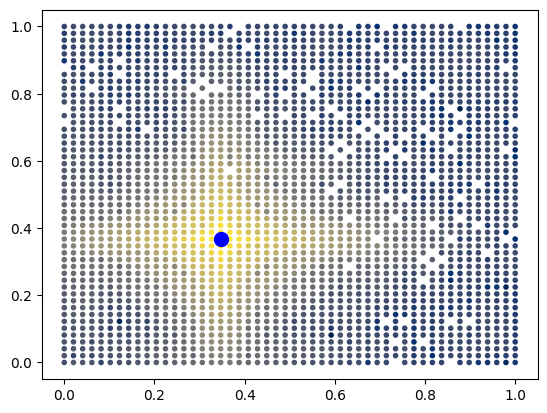

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pyKoLesky.cholesky import *
from pyKoLesky.ordering import *

torch.set_default_dtype(torch.float64)

N = len(x)
Theta = K

rho_values = torch.linspace(1, 10, 20)

KLerrors = []   # KL distances
errors = []

Perm, lengths = maximin(x)

Theta_ordered = Theta[Perm][:, Perm]

L = torch.linalg.cholesky(Theta_ordered)

Linv = torch.linalg.inv(L)

U = Linv.T

num = 2400

c = torch.abs(U[:num, num]).numpy()
plt.scatter(x[Perm[:num], 0].numpy(), x[Perm[:num], 1].numpy(), c = np.log(np.abs(U[:num, num])+1e-15)/np.log(10), marker='.', cmap = "cividis")
plt.plot(x[Perm[num], 0].numpy(), x[Perm[num], 1].numpy(), 'bo', markersize=10)